# Capsule Networks (CapsNets)

# Imports

In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Reproducibility

In [2]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)

# Load MNIST

In [42]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


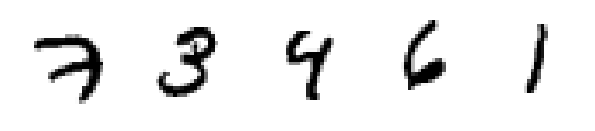

In [4]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

And these are the corresponding labels:

In [5]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

# Define Network Block

In [6]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [7]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [8]:
def capsule(input_layer, primary_caps_n_maps, primary_caps_n_dims,kernel_size,strides,
            secondary_n_caps, secondary_n_dims, name):

    def primary_capsule(input_layer,primary_caps_n_maps,primary_caps_n_dims,kernel_size,strides,name):
        
        conv_params = {
            "filters": primary_caps_n_maps * primary_caps_n_dims, # 256 convolutional filters
            "kernel_size": kernel_size,
            "strides": strides,
            "padding": "valid",
            "activation": tf.nn.relu
        }
        primary_conv = tf.layers.conv2d(input_layer, name=name+"_conv", **conv_params)
        primary_n_caps = primary_caps_n_maps * (int)(primary_conv.shape[1]) * (int)(primary_conv.shape[2])  # 1152 primary capsules
        primary_caps_raw = tf.reshape(primary_conv, [-1, primary_n_caps, primary_caps_n_dims],name=name+"_raw")
        primary_caps_output = squash(primary_caps_raw, name=name+"_output")
        return primary_caps_output
    
    def secondary_capsule(primary_layer,secondary_n_caps,secondary_n_dims,name):
        init_sigma = 0.01
        primary_n_caps = (int)(primary_layer.shape[1])
        primary_n_dims = (int)(primary_layer.shape[2])
        W_init = tf.random_normal(
            shape=(1, primary_n_caps, secondary_n_caps, secondary_n_dims, primary_n_dims),
            stddev=init_sigma, dtype=tf.float32, name=name+"_W_init")
        W = tf.Variable(W_init, name=name+"_W")
        batch_size = tf.shape(primary_layer)[0]
        W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name=name+"_W_tiled")
        primary_layer_expanded = tf.expand_dims(primary_layer, -1,
                                               name=name+"_primary_layer_expanded")
        primary_layer_tile = tf.expand_dims(primary_layer_expanded, 2,
                                           name=name+"_primary_layer_tile")
        primary_layer_tiled = tf.tile(primary_layer_tile, [1, 1, secondary_n_caps, 1, 1],
                                     name=name+"_primary_layer_tiled")
        secondary_caps_predicted = tf.matmul(W_tiled, primary_layer_tiled,
                                    name=name+"_predicted")
        raw_weights = tf.zeros([batch_size, primary_n_caps, secondary_n_caps, 1, 1],
                               dtype=np.float32, name=name+"_raw_weights")
        routing_weights = tf.nn.softmax(raw_weights, dim=2, name=name+"_routing_weights")
        weighted_predictions = tf.multiply(routing_weights, secondary_caps_predicted,
                                           name=name+"_weighted_predictions")
        weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                                     name=name+"_weighted_sum")
        secondary_cap_output_round_1 = squash(weighted_sum, axis=-2,
                                      name=name+"_output_round_1")
        secondary_cap_output_round_1_tiled = tf.tile(
                                    secondary_cap_output_round_1, [1, primary_n_caps, 1, 1, 1],
                                    name=name+"_output_round_1_tiled")
        agreement = tf.matmul(secondary_caps_predicted, secondary_cap_output_round_1_tiled,
                              transpose_a=True, name=name+"_agreement")
        raw_weights_round_2 = tf.add(raw_weights, agreement,
                                     name=name+"_raw_weights_round_2")
        routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                                dim=2,
                                                name=name+"_routing_weights_round_2")
        weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                                   secondary_caps_predicted,
                                                   name=name+"_weighted_predictions_round_2")
        weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                             axis=1, keep_dims=True,
                                             name=name+"_weighted_sum_round_2")
        secondary_cap_output_round_2 = squash(weighted_sum_round_2,
                                      axis=-2,
                                      name=name+"_output_round_2")
        return secondary_cap_output_round_2
    
    caps1_output = primary_capsule(input_layer=conv1,
                                   primary_caps_n_maps=primary_caps_n_maps,
                                   primary_caps_n_dims=primary_caps_n_dims,
                                   kernel_size=kernel_size,
                                   strides=strides,
                                   name=name+"_primary_layer")
    
    secondary_cap_output = secondary_capsule(caps1_output,
                                     secondary_n_caps=secondary_n_caps,
                                     secondary_n_dims=secondary_n_dims,
                                     name=name+"_secondary_layer")
    return secondary_cap_output

In [9]:
def margin_loss(input_capsule,name): 
    m_plus = 0.9
    m_minus = 0.1
    lambda_ = 0.5
    
    input_capsule_n_caps=(int)(input_capsule.shape[2])
    T = tf.one_hot(y, depth=input_capsule_n_caps, name="T")
    input_capsule_norm = safe_norm(input_capsule, axis=-2, keep_dims=True,
                                  name=name+"_input_caps_output_norm")
    present_error_raw = tf.square(tf.maximum(0., m_plus - input_capsule_norm),
                                  name=name+"_present_error_raw")
    present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                               name=name+"_present_error")
    absent_error_raw = tf.square(tf.maximum(0., input_capsule_norm - m_minus),
                                 name=name+"_absent_error_raw")
    absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                              name=name+"_absent_error")
    L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
               name="L")
    margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")
    return margin_loss

In [10]:
def prediction(input_capsule,name):
    proba = safe_norm(input_capsule, axis=-2, name=name+"_proba")
    proba_argmax = tf.argmax(proba, axis=2, name=name+"_proba_argmax")
    pred = tf.squeeze(proba_argmax, axis=[1,2], name=name+"_pred")
    return pred

In [11]:
def reconstruction(capsule_output,mask_flag,reconstruction_target,label,label_pred,name):
    n_hidden1 = 512
    n_hidden2 = 1024
    
    capsule_n_caps=(int)(capsule_output.shape[2])
    capsule_n_dims=(int)(capsule_output.shape[3])
    
    reconstruction_targets = tf.cond(mask_flag, # condition
                                     lambda: y,        # if True
                                     lambda: y_pred,   # if False
                                     name=name+"_reconstruction_targets")
    
    reconstruction_mask = tf.one_hot(reconstruction_targets,
                                     depth=capsule_n_caps,
                                     name=name+"_reconstruction_mask")
    
    reconstruction_mask_reshaped = tf.reshape(
        reconstruction_mask, [-1, 1, capsule_n_caps, 1, 1],
        name=name+"_reconstruction_mask_reshaped")
    
    capsule_output_masked = tf.multiply(
        capsule_output, reconstruction_mask_reshaped,
        name=name+"_capsule_output_masked")
    
    
    n_output = (int)(reconstruction_target.shape[1]) * (int)(reconstruction_target.shape[2])
    
    decoder_input = tf.reshape(capsule_output_masked,
                               [-1, capsule_n_caps * capsule_n_dims],
                               name=name+"_decoder_input")
    
    with tf.name_scope(name+"_decoder"):
        hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                                  activation=tf.nn.relu,
                                  name=name+"_hidden1")
        hidden2 = tf.layers.dense(hidden1, n_hidden2,
                                  activation=tf.nn.relu,
                                  name=name+"_hidden2")
        decoder_output = tf.layers.dense(hidden2, n_output,
                                         activation=tf.nn.sigmoid,
                                         name=name+"_decoder_output")
        
    reconstruction_target_flat = tf.reshape(reconstruction_target, [-1, n_output], name="X_flat")
    squared_difference = tf.square(reconstruction_target_flat - decoder_output,
                                   name=name+"_squared_difference")
    reconstruction_loss = tf.reduce_sum(squared_difference,
                                        name=name+"_reconstruction_loss")
    return reconstruction_loss,decoder_output

In [12]:
def loss_accuracy(margin_loss,reconstruction_loss,label,label_pred,name):
    alpha = 0.0005
    loss = tf.add(margin_loss, alpha * reconstruction_loss, name=name+"_loss")
    correct = tf.equal(y, y_pred, name=name+"_correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name=name+"_accuracy")
    return loss,accuracy

In [13]:
def interpret_output(output_capsule,output_vectors,n_samples,n_steps):
    def tweak_pose_parameters(output_vectors,n_steps=n_steps, min=-0.5, max=0.5):
        capsule_n_caps=(int)(output_vectors.shape[2])
        capsule_n_dims=(int)(output_vectors.shape[3])
        steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
        pose_parameters = np.arange(capsule_n_dims) # 0, 1, ..., 15
        tweaks = np.zeros([capsule_n_dims, n_steps, 1, 1, 1, capsule_n_dims, 1])
        tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
        output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
        return tweaks + output_vectors_expanded
    
    output_vectors_n_caps=(int)(output_vectors.shape[2])
    output_vectors_n_dims=(int)(output_vectors.shape[3])
    tweaked_vectors = tweak_pose_parameters(final_caps_output_value, n_steps=n_steps)
    tweaked_vectors_reshaped = tweaked_vectors.reshape([-1, 1, output_vectors_n_caps, output_vectors_n_dims, 1])
    
    tweak_labels = np.tile(mnist.test.labels[:n_samples], output_vectors_n_dims * n_steps)

    with tf.Session() as sess:
        saver.restore(sess, checkpoint_path)
        decoder_output_value = sess.run(
                decoder_output,
                feed_dict={output_capsule: tweaked_vectors_reshaped,
                           mask_with_labels: True,
                           y: tweak_labels})
        
    tweak_reconstructions = decoder_output_value.reshape([output_vectors_n_dims, n_steps, n_samples, 28, 28])
    return tweak_reconstructions

# Build Network

In [14]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")
mask_with_labels = tf.placeholder_with_default(False, shape=(),name="mask_with_labels")
learning_rate = tf.placeholder(tf.float32,name="learning_rate")

In [15]:
conv1 = tf.layers.conv2d(X, filters=128,kernel_size=3,
                         strides=1,padding="valid",
                         activation=tf.nn.relu,
                         name="conv1")
print(conv1)

Tensor("conv1/Relu:0", shape=(?, 26, 26, 128), dtype=float32)


In [16]:
capsule1 =  capsule(conv1, primary_caps_n_maps=64, primary_caps_n_dims=4,
                    kernel_size=5,strides=2,
                    secondary_n_caps=36, secondary_n_dims=8, name="capsule1")
print(capsule1)

Tensor("capsule1_secondary_layer_output_round_2/mul:0", shape=(?, 1, 36, 8, 1), dtype=float32)


In [17]:
capsule1_flat = tf.contrib.layers.flatten(capsule1)
print(capsule1_flat)

Tensor("Flatten/flatten/Reshape:0", shape=(?, 288), dtype=float32)


In [18]:
fc1 = tf.layers.dense(capsule1_flat, capsule1_flat.shape[1], activation=tf.nn.relu, name="fc1")
print(fc1)

Tensor("fc1/Relu:0", shape=(?, 288), dtype=float32)


In [19]:
capsule2_input = tf.reshape(fc1, [-1,6,6,8])
print(capsule2_input)

Tensor("Reshape_4:0", shape=(?, 6, 6, 8), dtype=float32)


In [20]:
capsule2 =  capsule(capsule2_input, primary_caps_n_maps=18, primary_caps_n_dims=8,
                    kernel_size=2,strides=1,
                    secondary_n_caps=10, secondary_n_dims=16, name="capsule2")
print(capsule2)

Tensor("capsule2_secondary_layer_output_round_2/mul:0", shape=(?, 1, 10, 16, 1), dtype=float32)


In [21]:
final_capsule = capsule2

margin_loss = margin_loss(final_capsule,name="margin_loss1") 

y_pred = prediction(final_capsule,name="pred_y")

reconstruction_loss,decoder_output =  reconstruction(capsule_output=final_capsule,
                                       mask_flag=mask_with_labels,
                                       reconstruction_target=X,
                                       label=y,
                                       label_pred=y_pred,
                                       name="X_recon")

loss,accuracy = loss_accuracy(margin_loss=margin_loss,
                              reconstruction_loss=reconstruction_loss,
                              label=y,
                              label_pred=y_pred,
                              name="Xy")



## Training Operations, Init and Saver

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss, name="training_op")
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Training

In [33]:
n_epochs = 10
batch_size = 8
learn_rate=0.00002
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./Deep_Capsnets_MNIST_Rev1/my_capsule_network"

In [ ]:


with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={learning_rate: learn_rate,
                            X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        save_path = saver.save(sess, checkpoint_path)
        if loss_val < best_loss_val:
        #    save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

64/Batch  
Epoch: 1  Val accuracy: 97.2%     Loss: 0.0775 (improved)  
Epoch: 2  Val accuracy: 98.2372%  Loss: 0.060644 (improved)  
Epoch: 1  Val accuracy: 98.3974%  Loss: 0.052211 (improved)  
Epoch: 1  Val accuracy: 98.4375%  Loss: 0.046997 (improved)  
8/Batch
Epoch: 1  Val accuracy: 98.6200%  Loss: 0.071876 (improved)  
Epoch: 2  Val accuracy: 98.6400%  Loss: 0.068825 (improved)  
Epoch: 3  Val accuracy: 98.7600%  Loss: 0.067111 (improved)  
Epoch: 4  Val accuracy: 98.7800%  Loss: 0.065605 (improved)  
Epoch: 5  Val accuracy: 98.8600%  Loss: 0.064468 (improved)  
Epoch: 6  Val accuracy: 98.9000%  Loss: 0.063310 (improved)  
Epoch: 7  Val accuracy: 98.9800%  Loss: 0.062470 (improved)  
Epoch: 8  Val accuracy: 98.9400%  Loss: 0.061917 (improved)  
Epoch: 9  Val accuracy: 98.9600%  Loss: 0.061039 (improved)  
Epoch: 1  Val accuracy: 98.9600%  Loss: 0.061235  
Epoch: 1  Val accuracy: 99.0200%  Loss: 0.060309 (improved)  
Epoch: 2  Val accuracy: 99.0400%  Loss: 0.060405  
Epoch: 3  Val accuracy: 99.0200%  Loss: 0.060176 (improved)  
Epoch: 4  Val accuracy: 99.0000%  Loss: 0.060044 (improved)  
Epoch: 5  Val accuracy: 99.0600%  Loss: 0.059920 (improved)  
Epoch: 6  Val accuracy: 99.0200%  Loss: 0.059867 (improved)  
Epoch: 7  Val accuracy: 99.0200%  Loss: 0.059836 (improved)  
Epoch: 8  Val accuracy: 99.0600%  Loss: 0.059702 (improved)  
Epoch: 9  Val accuracy: 99.0400%  Loss: 0.059828  

# Evaluation

In [35]:
n_iterations_test = mnist.test.num_examples // batch_size
n_iterations_test=200
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./Deep_Capsnets_MNIST_Rev1/my_capsule_network
Final test accuracy: 98.9375%  Loss: 0.059651   


We reach 99.43% accuracy on the test set. Pretty nice. :)

# Predictions

In [43]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    final_caps_output_value, decoder_output_value, y_pred_value = sess.run(
            [final_capsule, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./Deep_Capsnets_MNIST_Rev1/my_capsule_network


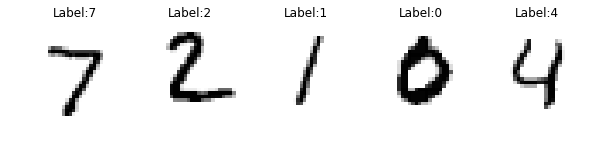

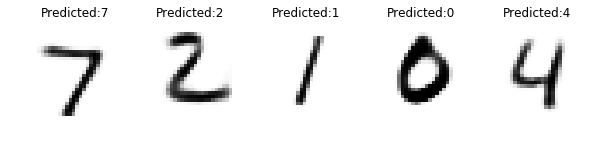

In [44]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()


# Interpreting the Output Vectors

In [45]:
n_steps=11
tweak_reconstructions = interpret_output(final_capsule, final_caps_output_value,n_samples=n_samples,n_steps=n_steps)

INFO:tensorflow:Restoring parameters from ./Deep_Capsnets_MNIST_Rev1/my_capsule_network


Tweaking output dimension #0


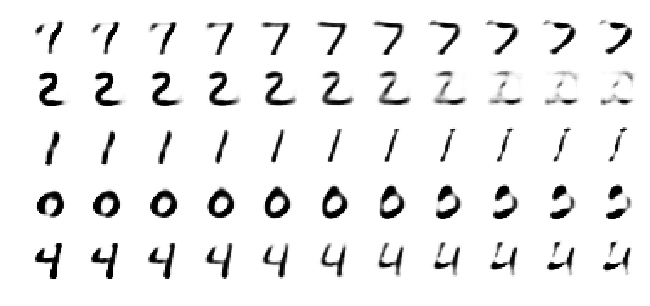

Tweaking output dimension #1


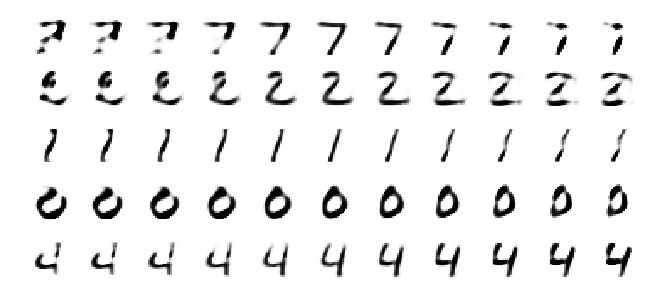

Tweaking output dimension #2


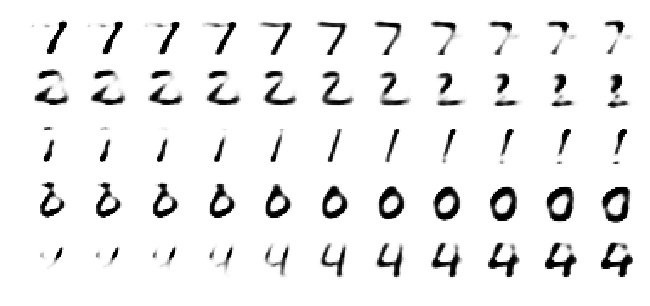

Tweaking output dimension #3


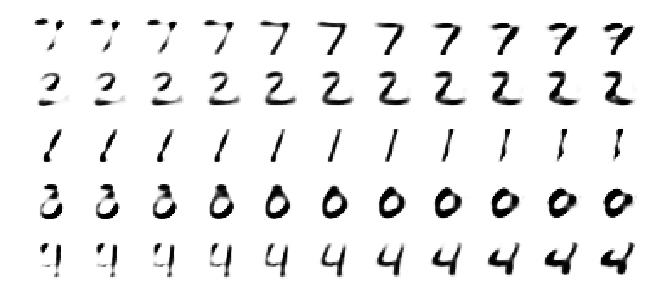

Tweaking output dimension #4


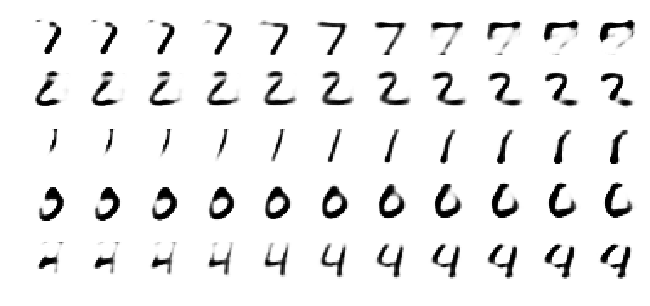

Tweaking output dimension #5


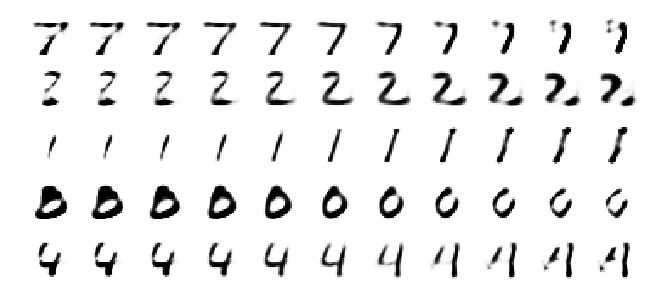

Tweaking output dimension #6


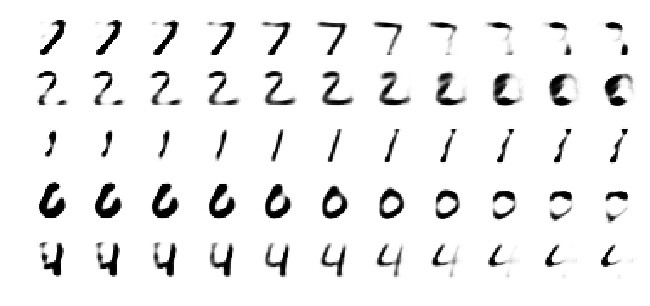

Tweaking output dimension #7


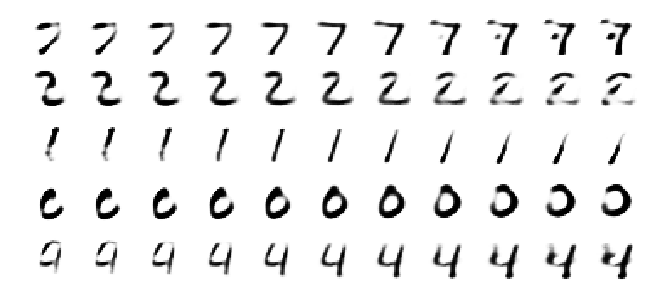

Tweaking output dimension #8


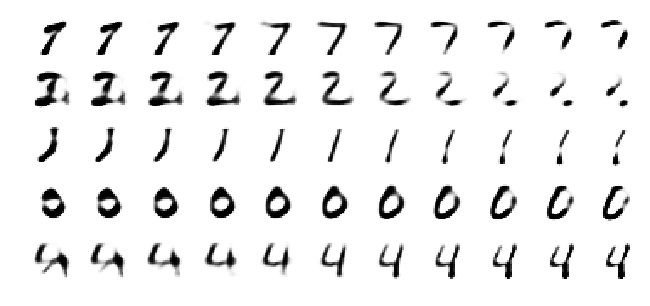

Tweaking output dimension #9


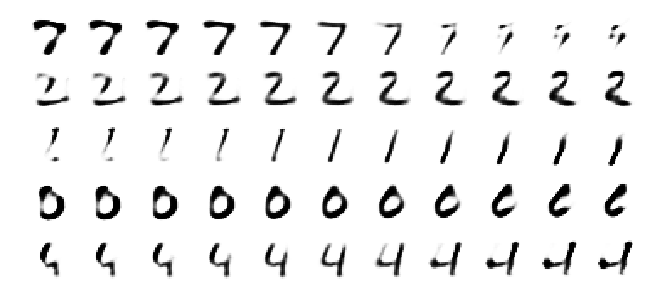

Tweaking output dimension #10


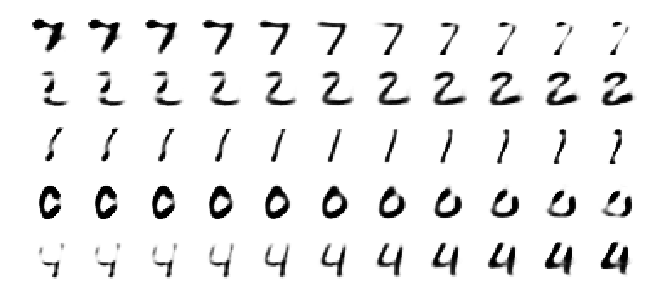

Tweaking output dimension #11


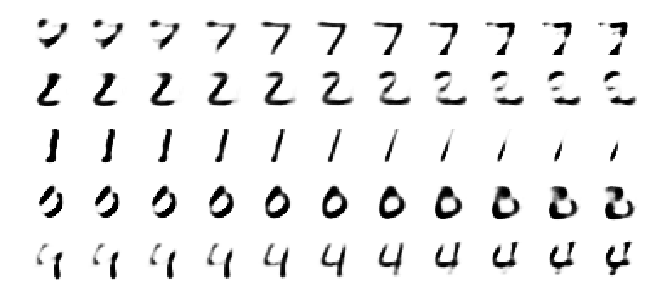

Tweaking output dimension #12


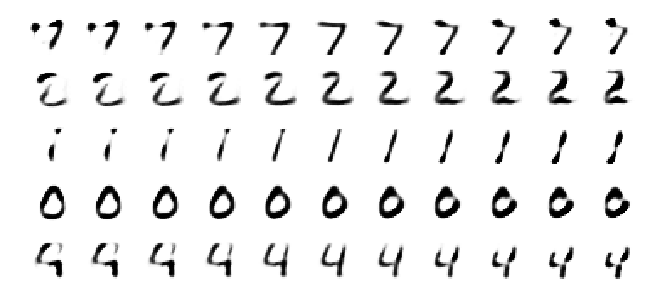

Tweaking output dimension #13


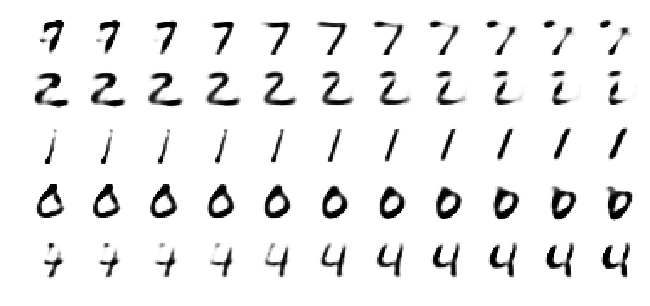

Tweaking output dimension #14


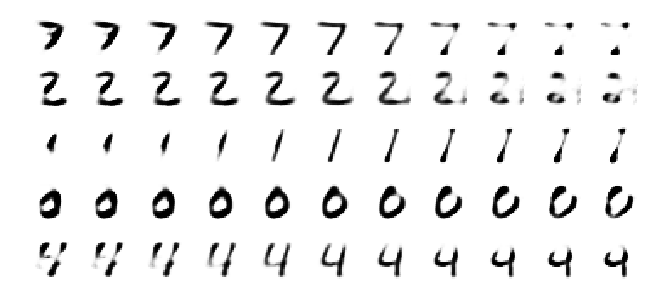

Tweaking output dimension #15


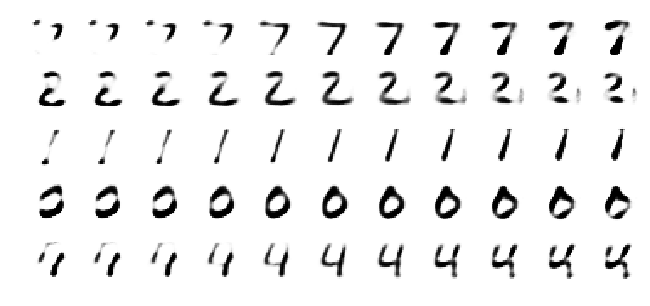

In [46]:
for dim in range(16):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.0, n_samples / 1.0))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()